# Retrieval Augmented Generation (RAG) App: Part 1
1. Instala y actualiza silenciosamente langchain, langchain-community y langchain-chroma

In [55]:
%pip install --quiet --upgrade langchain langchain-community langchain-chroma

Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
openai 1.68.0 requires numpy>=2.0.2, but you have numpy 1.26.4 which is incompatible.


2. Configura variables de entorno para rastreo y autenticación de LangSmith

In [ ]:
import getpass
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = "key"

3. Configura la clave de API de OpenAI para acceder a sus modelos

In [57]:
%pip install -qU langchain-openai

Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-chroma 0.2.2 requires numpy<2.0.0,>=1.22.4; python_version < "3.12", but you have numpy 2.2.4 which is incompatible.


4. Crea una instancia del modelo ChatOpenAI GPT-4 mini

In [ ]:
import getpass
import os

os.environ["OPENAI_API_KEY"] = "key OpenAi"

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [59]:
%pip install -qU langchain-core
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

Note: you may need to restart the kernel to use updated packages.


5. Instala BeautifulSoup para analizar HTML

In [60]:
%pip install beautifulsoup4

Note: you may need to restart the kernel to use updated packages.


6. Carga y divide el contenido de un blog en fragmentos para indexación:


In [61]:
import bs4
from langchain import hub
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

- Carga contenido web y extrae solo elementos relevantes

In [62]:
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

- Divide el documento en fragmentos de 1000 caracteres con superposición de 200

In [63]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

- Crea un vector store e indexa los fragmentos

In [64]:
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings())

- Configura la recuperación y generación usando los fragmentos indexados

In [65]:
retriever = vectorstore.as_retriever()
prompt = hub.pull("rlm/rag-prompt")

- Formatea los fragmentos recuperados

In [66]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

- Configura la cadena de recuperación y generación (RAG) para responder preguntas

In [67]:

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

- Ejecuta una pregunta de ejemplo usando la cadena RAG

In [68]:
rag_chain.invoke("What is Task Decomposition?")

'Task Decomposition refers to the process of breaking down a complicated task into smaller, more manageable steps. It often utilizes techniques like Chain of Thought (CoT), which instructs models to “think step by step” to enhance performance on complex tasks. This approach helps clarify the reasoning process and can be guided by prompts, specific instructions, or human input.'

7. Limpia y elimina la colección en la base de datos de vectores

In [69]:
vectorstore.delete_collection()

8. Extrae el título, los encabezados y el contenido de una página web específica, filtrando solo las secciones necesarias. Luego, carga los datos en un documento y muestra la longitud del contenido extraído.

In [70]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()
len(docs[0].page_content)

43130

9. Imprime los primeros 500 caracteres del contenido cargado para verificar

In [71]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


10. Configura un divisor de texto que incluye índices de inicio

In [72]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


11. Muestra la longitud del contenido del primer fragmento

In [73]:
len(all_splits[0].page_content)

969

12. Muestra los metadatos del décimo fragmento

In [74]:
all_splits[10].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 7055}

13. Crea y almacena los fragmentos en una base de datos de vectores

In [75]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

vectorstore = Chroma.from_documents(documents=all_splits, embedding=OpenAIEmbeddings())

Configura un recuperador basado en búsqueda por similitud y especifica que devuelva los seis documentos más relevantes. Luego, realiza una consulta para obtener información sobre enfoques de descomposición de tareas y muestra la cantidad de documentos recuperados.

In [76]:
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 6})
retrieved_docs = retriever.invoke("What are the approaches to Task Decomposition?")
len(retrieved_docs)

6

In [77]:
print(retrieved_docs[0].page_content)

Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.
Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.


In [78]:
%pip install -qU langchain-openai

Note: you may need to restart the kernel to use updated packages.


Configuramos otra vez OpenAI y crea el modelo GPT-4 mini 

In [ ]:
import getpass
import os

os.environ["OPENAI_API_KEY"] = "key"

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [80]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [81]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [82]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [83]:
%pip install langchain langgraph

from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

Note: you may need to restart the kernel to use updated packages.


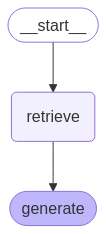

In [84]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [85]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: []


Answer: Task decomposition is the process of breaking down a complex task into smaller, more manageable sub-tasks. This approach helps in organizing work and making it easier to tackle each component systematically. It can improve efficiency and clarity in problem-solving and project management.


In [86]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': []}}

----------------

{'generate': {'answer': 'Task Decomposition is the process of breaking down a complex task into smaller, more manageable sub-tasks. This approach helps in simplifying problem-solving and enhances efficiency in completing the overall task. It allows individuals or systems to focus on one aspect at a time, leading to better organization and execution.'}}

----------------



In [87]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

|Task| De|composition| is| the| process| of| breaking| down| a| complex| task| into| smaller|,| more| manageable| sub|-t|asks| or| components|.| This| approach| helps| in| understanding| and| organizing| the| tasks| effectively|,| making| them| easier| to| accomplish|.| It| is| commonly| used| in| various| fields|,| including| project| management| and| artificial| intelligence|.||

Creamos una cadena para probar la funcionalidad